In [10]:
# import

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import time
from datetime import datetime
from scipy.fft import fft
from scipy.interpolate import interp1d
import re

In [11]:
# define functions will be used

def get_time(s):
    hr = []; minute = []; sec = [];
    A = [m.start() for m in re.finditer('_', s)];
    hr = s[A[14] + 1] + s[A[14] + 2];
    minute = s[A[15] + 1] + s[A[15] + 2];
    sec = s[A[16] + 1]+s[A[16] + 2];
    return hr, minute, sec

def array_merge(A):
    tmp = np.array([]);
    A = np.array(A);
    for i in range(len(A)):
        tmp = np.append(tmp,A[i]);
    return tmp

In [12]:
# Some basic settings

Sample_Rate = 400;
Sample_Period = 300;
r_normal = 0.001;
Amp_max = 0.01; # 600/60000
r_normal = 0.001;

foldername = '主機2020.03';
folderpwd = 'D:' + os.sep + '震動資料' + os.sep + foldername;
files = [f for f in os.listdir(folderpwd) if os.path.isfile(os.path.join(folderpwd, f))];

start_date = '2020_3_1';
end_date = '2020_3_31';
t1 = time.mktime(datetime.strptime(start_date,"%Y_%m_%d").timetuple());
t2 = time.mktime(datetime.strptime(end_date,"%Y_%m_%d").timetuple());
dd = (t2-t1)/86400 + 1;

f0 = np.linspace(1/Sample_Period, Sample_Rate/2, int(Sample_Period*Sample_Rate/2));

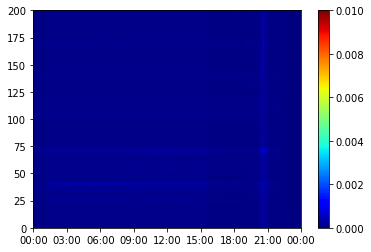

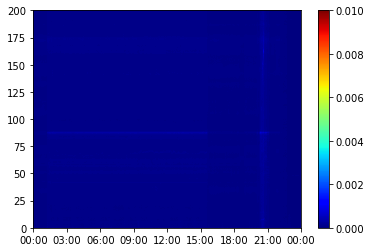

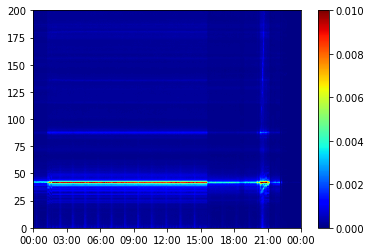

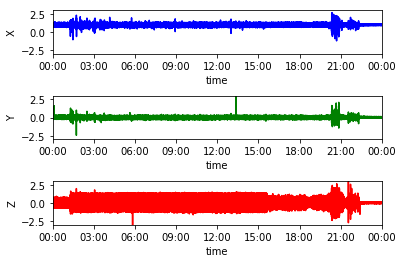

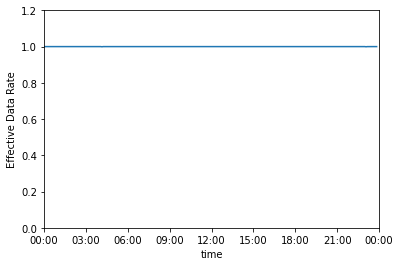

In [13]:
# Get X Y Z file and run fft

# run setting days
for dt in range(6,7): #range(dd)
    
    # Some settings
    Xfile = []; Yfile = []; Zfile = [];
    FX2 = []; FY2 = []; FZ2 = [];
    XA = []; YA = []; ZA = [];
    NA = []; t_old = []; 
    
    Day_Stamp = datetime.fromtimestamp(t1 + dt * 86400);
    Day = Day_Stamp.strftime("%Y_%#m_%#d");
    Daycheck = Day + '_';
    
    Xfile = [files[i] for i in range(len(files)) if ((Daycheck in files[i]) & ('Ch_X' in files[i]))]
    Yfile = [files[i] for i in range(len(files)) if ((Daycheck in files[i]) & ('Ch_Y' in files[i]))]
    Zfile = [files[i] for i in range(len(files)) if ((Daycheck in files[i]) & ('Ch_Z' in files[i]))]
    
    # check file existence
    if (len(Xfile) == 0 ):
        print('File error: Xfile is empty.');
        break;
    elif(len(Yfile) == 0):
        print('File error: Yfile is empty.');
        break;
    elif(len(Zfile) == 0):
        print('File error: Zfile is empty.');
        break;

    # store data and run for each file
    for fileid in range(len(Xfile)): #range(len(Xfile))
        
        X = []; Y = []; Z = [];
        t_x = []; t_y = []; t_z = [];
        
        # get time info
        h, m, s = get_time(Xfile[fileid]);
        if('下' in Xfile[fileid]):
            c = 12;
        else:
            c = 0;
        h = str( int(h)%12 + c );
        current_date = Day + ':' + h + ':' + m + ':' + s;
        current_stamp = time.mktime(datetime.strptime(current_date,"%Y_%m_%d:%H:%M:%S").timetuple());
        
        # get three axis' data
        filepwd = folderpwd + os.sep + Xfile[fileid];
        loadx = np.loadtxt(filepwd, skiprows = 22, encoding = 'utf-8', delimiter = ';');
        t_x = [loadx[j][0] for j in range(len(loadx)) if(loadx[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]
        X = [loadx[j][1] for j in range(len(loadx)) if(loadx[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]

        filepwd = folderpwd + os.sep + Yfile[fileid];
        loady = np.loadtxt(filepwd, skiprows = 22, encoding = 'utf-8', delimiter = ';');
        t_y = [loady[j][0] for j in range(len(loady)) if(loady[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]
        Y = [loady[j][1] for j in range(len(loady)) if(loady[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]
            
        filepwd = folderpwd + os.sep + Zfile[fileid];
        loadz = np.loadtxt(filepwd, skiprows = 22, encoding = 'utf-8', delimiter = ';');
        t_z = [loadz[j][0] for j in range(len(loadz)) if(loadz[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]
        Z = [loadz[j][1] for j in range(len(loadz)) if(loadz[j][0] < ( (Sample_Rate * Sample_Period) + 10) )]
        
        # empty reaction
        empty_controller = 0
        if not t_x:
            print(Xfile[fileid], 'has no time index value.')
            empty_controller = 1
        if not t_x:
            print(Yfile[fileid], 'has no time index value.')
            empty_controller = 1
        if not t_x:
            print(Zfile[fileid], 'has no time index value.')
            empty_controller = 1
        if empty_controller:
            continue
        
        t_old.append(current_stamp);
        
        # interpolate        
        t = np.linspace(min(t_x), max(t_x), int(max(t_x) - min(t_x) + 1), dtype = int);
        X = interp1d(t_x,X)(t);
        Y = interp1d(t_y,Y)(t);
        Z = interp1d(t_z,Z)(t);
        
        XA.append(X);
        YA.append(Y);
        ZA.append(Z);           
        
        N = len(t);
        NA.append(N);
        TT = N/Sample_Rate;
        f = np.linspace(1/TT,Sample_Rate/2,int(N/2));
        L = len(f);
        
        # three axis fft
        F = fft(X)/len(X);
        F = np.delete(F, list(range(L+1,len(F))))
        F = np.delete(F,0);
        FX = interp1d(f,abs(F))(f0[f0 > 1/TT]);
        FX = np.insert(FX,0,0);
        FX2.append(FX);
        
        F = fft(Y)/len(Y);
        F = np.delete(F, list(range(L+1,len(F))))
        F = np.delete(F,0);
        FY = interp1d(f,abs(F))(f0[f0 > 1/TT]);
        FY = np.insert(FY,0,0);
        FY2.append(FY);
        
        F = fft(Z)/len(Z);
        F = np.delete(F, list(range(L+1,len(F))))
        F = np.delete(F,0);
        FZ = interp1d(f,abs(F))(f0[f0 > 1/TT]);
        FZ = np.insert(FZ,0,0);
        FZ2.append(FZ);

    tt = sorted(t_old);
    ttindex = np.argsort(t_old);
    ttindex = ttindex[ttindex!=0];
    
    T = np.array(FX2);FX2 = T[ttindex];
    T = np.array(FY2);FY2 = T[ttindex];
    T = np.array(FZ2);FZ2 = T[ttindex];
    T = np.array(NA);NA = T[ttindex];
    T = np.array(XA);XA = T[ttindex];
    T = np.array(YA);YA = T[ttindex];
    T = np.array(ZA);ZA = T[ttindex];

    # check time index existence
    if (len(tt) == 0):
        print('Error: no time index.');
        break;
    
    tlen = len(tt);
    time_label_list = ['00:00', '03:00', '06:00', '09:00', '12:00', 
                       '15:00', '18:00','21:00','00:00'];
    Ttick = np.linspace(0,tlen,9);
    
    time3 = time.time();
    
    # plot time-freq for each axis
    figX, axX = plt.subplots();
    img = axX.imshow(np.matrix.transpose(FX2) , cmap = 'jet', vmin = 0, vmax = Amp_max,
                    aspect = 'auto', origin = 'lower', extent = [0,tlen,0,200]);
    axX.set_xticks(Ttick);
    axX.set_xticklabels(time_label_list);
    figX.colorbar(img);
    figname = Day + 'X';
    plt.savefig(figname,dpi=600);
    
    figY, axY = plt.subplots();
    img = axY.imshow(np.matrix.transpose(FY2) , cmap = 'jet', vmin = 0, vmax = Amp_max,
                    aspect = 'auto', origin = 'lower', extent = [0,tlen,0,200]);
    axY.set_xticks(Ttick);
    axY.set_xticklabels(time_label_list);
    figY.colorbar(img);
    figname = Day + 'Y';
    plt.savefig(figname,dpi=600);
    
    figZ, axZ = plt.subplots();
    img = axZ.imshow(np.matrix.transpose(FZ2) , cmap = 'jet', vmin = 0, vmax = Amp_max,
                    aspect = 'auto', origin = 'lower', extent = [0,tlen,0,200]);
    axZ.set_xticks(Ttick);
    axZ.set_xticklabels(time_label_list);
    figZ.colorbar(img);
    figname = Day + 'Z';
    plt.savefig(figname,dpi=600);
    
    # plot raw data
    XA = array_merge(XA);
    YA = array_merge(YA);
    ZA = array_merge(ZA);
    Xtick = np.linspace(0,len(XA),9);
    Ytick = np.linspace(0,len(YA),9);
    Ztick = np.linspace(0,len(ZA),9);
    
    figT = plt.figure();
    axT = figT.add_subplot(111);
    axT.spines['top'].set_color('none');
    axT.spines['bottom'].set_color('none');
    axT.spines['left'].set_color('none');
    axT.spines['right'].set_color('none');
    axT.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False);
    
    axT1 = figT.add_subplot(311);
    plt.plot(XA,'b');
    plt.xlabel('time');
    plt.ylabel('X');
    plt.xlim([0,len(XA)]);
    plt.ylim([-3,3]);
    axT1.set_xticks(Xtick);
    axT1.set_xticklabels(time_label_list);
    
    axT2 = figT.add_subplot(312);
    plt.plot(YA,'g');
    axT2.set_xticks(Ytick);
    axT2.set_xticklabels(time_label_list);
    plt.xlabel('time');
    plt.ylabel('Y');
    plt.xlim([0,len(YA)]);
    plt.ylim([-3,3]);
    
    axT3 = figT.add_subplot(313);
    plt.plot(ZA,'r');
    axT3.set_xticks(Ztick);
    axT3.set_xticklabels(time_label_list);
    plt.xlabel('time');
    plt.ylabel('Z');
    plt.xlim([0,len(ZA)]);
    plt.ylim([-3,3]);
    plt.tight_layout();
    figname = Day + 'T';
    plt.savefig(figname,dpi=600);
    
    figN = plt.figure();
    axN = figN.add_subplot();
    plt.plot(np.array(NA)/120000);
    axN.set_xticks(np.linspace(0,tlen,9));
    axN.set_xticklabels(time_label_list);
    plt.xlim([0,len(tt)]);
    plt.ylim([0,1.2]);
    plt.xlabel('time');
    plt.ylabel('Effective Data Rate');
    figname = Day + 'N';
    plt.savefig(figname,dpi=600);
    time4 = time.time();

In [7]:
print(XA.flatten())

[array([1.0021, 1.0079, 1.0224, ..., 1.005 , 1.0079, 0.9819])
 array([0.9616, 1.0021, 0.9905, ..., 0.9992, 1.0224, 0.9442])
 array([0.9616, 1.0282, 1.0166, ..., 0.9442, 1.005 , 1.0456])
 array([1.005 , 1.0282, 1.0166, ..., 1.0224, 0.9819, 1.0137])
 array([0.9645, 0.9442, 0.9848, ..., 0.9992, 0.9963, 0.9819])
 array([0.979 , 0.9587, 0.9616, ..., 0.9963, 0.979 , 0.9616])
 array([0.9732, 1.0195, 0.9645, ..., 1.0253, 0.9819, 0.9413])
 array([0.9703, 0.9703, 0.9616, ..., 0.9558, 0.9529, 1.0137])
 array([1.0108, 0.9529, 0.9413, ..., 1.0079, 1.0282, 0.9877])
 array([1.0282, 0.9413, 0.9848, ..., 0.9934, 1.0369, 1.0253])
 array([0.9934, 0.9761, 0.9645, ..., 1.0079, 1.0311, 0.9732])
 array([0.9761, 0.9963, 0.9848, ..., 0.9819, 1.0108, 1.0108])
 array([1.118 , 0.9355, 0.9963, ..., 0.979 , 0.9761, 1.0079])
 array([1.005 , 1.0108, 0.979 , ..., 0.9905, 1.0021, 0.979 ])
 array([1.0021, 0.9905, 1.0166, ..., 0.979 , 0.9674, 0.95  ])
 array([0.9819, 1.0746, 0.9819, ..., 0.9848, 1.0224, 0.9616])
 array([